In [11]:
import os 
import string
from string import printable
import numpy as np
import pandas as pd
import re
import cv2
from tqdm import tqdm
from collections import defaultdict, Counter

from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [12]:
PATH = '/kaggle/input/nomnaocr/Patches/'
patches = open(PATH + 'Train.txt', "r").read().splitlines()
patches_val = open(PATH + 'Validate.txt', "r").read().splitlines()
print(len(patches))
print(len(patches_val))

30654
7664


In [13]:
PATH1 = '/kaggle/input/new-nom-dataset/generated_augmented/'
patches1 = open(PATH1 + 'train.txt', "r").read().splitlines()
patches_val1 = open(PATH1 + 'val.txt', "r").read().splitlines()
print(len(patches1))
print(len(patches_val1))

162594
40648


In [14]:
PATH2 = '/kaggle/input/handwritting-nom-dataset/handwritten/patches_preprocessed/'
patches2 = open(PATH2 + 'train.txt', "r").read().splitlines()
patches_val2 = open(PATH2 + 'val.txt', "r").read().splitlines()
print(len(patches2))
print(len(patches_val2))

8002
2000


In [15]:
def is_clean_text(text):
    not_nom_chars = r'\sáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ'
    pattern = re.compile(f'[{not_nom_chars}{re.escape(printable)}]')
    return not bool(re.search(pattern, text.lower()))

In [16]:
def convert_list(patches):
    filenames = []
    texts = []
    for line in patches:
        img_path, text = line.rstrip('\n').split('\t')
        text = text.strip().lower()
        if is_clean_text(text):
            filenames.append(PATH + img_path)
            texts.append(text)
    # Convert to dataframe    
    raw_data = {
            "filename": filenames , 
            "text": texts
        }
    df = pd.DataFrame(raw_data, columns=["filename", "text"])
    return df

In [17]:
def convert_list1(patches):
    filenames = []
    texts = []
    for i in range(0,len(patches),2):
        img_path = patches[i]
        text = patches[i + 1].strip().lower()
        filenames.append(PATH1 + img_path)
        texts.append(text)
    # Convert to dataframe    
    raw_data = {
            "filename": filenames , 
            "text": texts
        }
    df = pd.DataFrame(raw_data, columns=["filename", "text"])
    return df

In [18]:
def convert_list2(patches):
    filenames = []
    texts = []
    for i in range(0,len(patches),2):
        img_path = patches[i]
        text = patches[i + 1].strip().lower()
        filenames.append(PATH2 + img_path)
        texts.append(text)
    # Convert to dataframe    
    raw_data = {
            "filename": filenames , 
            "text": texts
        }
    df = pd.DataFrame(raw_data, columns=["filename", "text"])
    return df

In [19]:
df_train = convert_list(patches)
df_val = convert_list(patches_val)
df_train1 = convert_list1(patches1)
df_val1 = convert_list1(patches_val1)
df_train2 = convert_list2(patches2)
df_val2 = convert_list2(patches_val2)

df_train1 = df_train1.append(df_train2)
df_val1 = df_val1.append(df_val2)
df_train = df_train.append(df_train1)
df_val = df_val.append(df_val1)
df_train.head()

,filename,text
0,/kaggle/input/nomnaocr/Patches/DVSKTT-4 Ban ky...,不得棄本遂末并托以販賣技術游足游手其有
1,/kaggle/input/nomnaocr/Patches/Tale of Kieu 18...,㐌衝身世群算浽芇
2,/kaggle/input/nomnaocr/Patches/DVSKTT-5 Ban ky...,象七隻來献營門王大喜九月捕得吳廷峩
3,/kaggle/input/nomnaocr/Patches/Tale of Kieu 18...,𢚸貞払𡏡劳刀󰡪蜍
4,/kaggle/input/nomnaocr/Patches/DVSKTT-4 Ban ky...,十一月除税使鋪正等職令勑旨󰱥今各税務


In [20]:
df_train.shape

(115557, 2)

# Encode Label

In [21]:
class convertLabel(object):
    """
    Convert between str and label.
    """
    def __init__(self, labels):
        self.vocabs = dict(Counter(''.join(labels)).most_common())
        # Mapping integers back to original characters
        self.idx2char = {k:v for k,v in enumerate(self.vocabs, start=0)}
        # Mapping characters to integers
        self.char2idx = {v:k for k,v in self.idx2char.items()}
        
    def vocab_size(self):
        return len(self.vocabs)
    
    def encode(self, text_batch):
        text_batch_targets_lens = [len(text) for text in text_batch]
        text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)

        text_batch_concat = "".join(text_batch)
        text_batch_targets = [self.char2idx[c] if c in self.vocabs.keys() else -1 for c in text_batch_concat]
        text_batch_targets = torch.IntTensor(text_batch_targets)

        return text_batch_targets, text_batch_targets_lens
    
    def decode(self, text_batch_logits):
        text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
        text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

        text_batch_tokens_new = []
        for text_tokens in text_batch_tokens:
            text = [self.idx2char[idx] for idx in text_tokens]
            text = "".join(text)
            text_batch_tokens_new.append(text)

        return text_batch_tokens_new

In [22]:
labels = df_train['text'].append(df_val['text'])
converter = convertLabel(labels = labels)

# Data Preparation

In [23]:
class NomNaDataset(Dataset):
    """
        df: dataframe
        root_dir: directory of root
    """
    def __init__(self, df, img_width, img_height):
        self.img_labels = df
        self.img_width = img_width
        self.img_height = img_height
       
    def __len__(self):
        return len(self.img_labels)
       
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_path = self.img_labels.iloc[idx, 0]
        label = self.img_labels.iloc[idx, 1]
        image = Image.open(img_path).convert('RGB')
        if self.checkTranspose(image):
            image = image.transpose(Image.Transpose.ROTATE_270) # Rotate image
        #image = image.transpose(Image.Transpose.ROTATE_270) # Rotate image
        image = self.resize(image)
        image = self.transform(image)        
    
        return image, label
    
    def checkTranspose(self,img):
        flag = True
        img = np.array(img)
        h, w, c = img.shape
        if h > w:
            flag = False
        return flag
    
    def resize(self, img):
        img = np.array(img)
        h, w, c = img.shape
        height = self.img_height  
        width = int(w * height / h)
        if width >= self.img_width:
            img = cv2.resize(img, (self.img_width, self.img_height))
        else:
            img = cv2.resize(img, (width, height))
            img_pad = np.zeros((self.img_height, self.img_width, c), dtype=img.dtype)
            img_pad[:] = 255 
            img_pad[:height, :width, :] = img
            img = img_pad
        img = Image.fromarray(img)
        return img
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [24]:
img_height, img_width = 432, 48 # Image size
train_dataset = NomNaDataset(df = df_train,
                             img_width = img_width, 
                             img_height = img_height)                     

val_dataset = NomNaDataset(df = df_val,
                           img_width = img_width, 
                           img_height = img_height)

In [25]:
num_workers = 4
BATCH_SIZE = 32
EVAL_BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, 
                      batch_size=BATCH_SIZE, 
                      num_workers = num_workers,
                      shuffle =True)

val_loader = DataLoader(val_dataset, 
                      batch_size=EVAL_BATCH_SIZE,
                      shuffle = False,
                      num_workers = num_workers)

In [26]:
# image_batch, text_batch = next(iter(train_loader))
# print(image_batch.size(), text_batch)

# Build model

In [27]:
resnet = resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [28]:
class CRNN(nn.Module):
    
    def __init__(self, vocab_size, rnn_hidden_size=256, dropout=0.1):
        super(CRNN, self).__init__()
        self.vocab_size = vocab_size
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(2, 2), stride=1, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(512, 512)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=2*rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, self.vocab_size)
        
        
    def forward(self, conv):
        """
        ------:size sequence:------
        torch.Size([batch_size, 3, 432, 48]) -- IN:
        torch.Size([batch_size, 256, 27, 3]) -- CNN blocks 1
        torch.Size([batch_size, 256, 26, 2]) -- CNN blocks 2
        torch.Size([batch_size, 26, 256, 2]) -- permuted 
        torch.Size([batch_size, 26, 512]) -- Linear #1
        torch.Size([batch_size, 26, 256]) -- IN GRU 
        torch.Size([batch_size, 26, 256]) -- OUT GRU 
        torch.Size([batch_size, 52, 512]) -- skip_connection
        torch.Size([batch_size, 52, vocab_size]) -- Linear #2
        torch.Size([52, batch_size, vocab_size]) -- :OUT
        """
        conv = self.cnn_p1(conv)

        conv = self.cnn_p2(conv)
        
        conv = conv.permute(0, 2, 1, 3) 
         
        batch_size = conv.size(0)
        T = conv.size(1)
        conv = conv.reshape(batch_size, T, -1) 
        
        feature_map = self.linear1(conv)
        
        batch, _ = self.rnn1(feature_map)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        
        batch, _ = self.rnn2(batch)
        x = torch.cat([feature_map, batch], 1)
        x = self.linear2(x)
        
        x = x.permute(1, 0, 2) 
        
        return x

In [29]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# CTC Loss Function

In [30]:
criterion = nn.CTCLoss(blank=0)

In [31]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(DEVICE) # [batch_size] 
    
    text_batch_targets, text_batch_targets_lens = converter.encode(text_batch)

    loss = criterion(text_batch_logps, text_batch_targets, 
                     text_batch_logps_lens, text_batch_targets_lens)
    
    return loss

# Train model

In [32]:
torch.manual_seed(0)

# Hyperparameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = converter.vocab_size()
rnn_hidden_size = 256
dropout = 0.1

model = CRNN(vocab_size, rnn_hidden_size=rnn_hidden_size, dropout = dropout)
# init weights
model.apply(weights_init)
#model.load_state_dict(torch.load('/kaggle/input/new-weight/crnn_pretrained1.pt'))

model = model.to(DEVICE)

In [33]:
learning_rate = 1.0
clip_norm = 5

optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

In [34]:
# def load_checkpoint(filename):
#         checkpoint = torch.load(filename)
#         optimizer.load_state_dict(checkpoint['optimizer'])
#         model.load_state_dict(checkpoint['state_dict'])

In [35]:
# load_checkpoint('/kaggle/input/new-checkpoints/crnn_checkpoint1 (1).pth')

In [36]:
def train_batch(model, image_batch, text_batch, optimizer, device):
    model.train()
    optimizer.zero_grad()
    text_batch_logits = model(image_batch.to(device))
    loss = compute_loss(text_batch, text_batch_logits)
    iteration_loss = loss.item()
        
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), clip_norm)
    optimizer.step()

    return iteration_loss

In [37]:
def evaluate_batch(model, dataloader, device):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for image_batch, text_batch in train_loader:
            
            text_batch_logits = model(image_batch.to(device))
            loss = compute_loss(text_batch, text_batch_logits)
            epoch_loss += loss.item()
 
    return epoch_loss / len(dataloader)

In [38]:
print('TRAINING PROCESS:')
print('-'*100)
NUM_EPOCHS = 40
i = 1
epoch_losses = []
val_losses = []
iteration_losses = []
num_updates_epochs = []

valid_every = 5
show_interval = 700
best_valid_loss = float('inf')

for epoch in range(1, NUM_EPOCHS+1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}: ")
    epoch_loss_list = [] 
    for image_batch, text_batch in tqdm(train_loader, leave=False): 
        iteration_loss = train_batch(model, image_batch, text_batch, optimizer, DEVICE)
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        
        if i % show_interval == 0:
            print('Train batch loss[',i, ']: ', np.mean(epoch_loss_list))
        i += 1
        
    epoch_loss = np.mean(epoch_loss_list)
    print("--> Train loss: {}".format(epoch_loss))
    
    if epoch % valid_every == 0:
        val_loss = evaluate_batch(model, val_loader, DEVICE)
        print("--> Val loss: {}".format(val_loss))
        val_losses.append(val_loss)
        if val_loss < best_valid_loss:
            best_valid_loss = val_loss
            prefix = 'crnn'
            loss = val_loss
            save_model_path = os.path.join('./checkpoint/',f'{prefix}_{i:06}_loss{loss}.pt')
            path, _ = os.path.split(save_model_path)
            os.makedirs(path, exist_ok=True)
            torch.save(model.state_dict(), save_model_path)
            print('Save model at ', save_model_path)
    epoch_losses.append(epoch_loss)

TRAINING PROCESS:
----------------------------------------------------------------------------------------------------
Epoch 1/40: 


 19%|█▉        | 701/3612 [01:12<04:40, 10.39it/s]

Train batch loss[ 700 ]:  8.783054984637669


 39%|███▉      | 1400/3612 [02:17<03:06, 11.89it/s]

Train batch loss[ 1400 ]:  8.31731403861727


 58%|█████▊    | 2101/3612 [03:23<03:04,  8.19it/s]

Train batch loss[ 2100 ]:  8.02860308011373


 77%|███████▋  | 2799/3612 [04:29<01:10, 11.47it/s]

Train batch loss[ 2800 ]:  7.754802425248283


 97%|█████████▋| 3502/3612 [05:39<00:10, 10.87it/s]

Train batch loss[ 3500 ]:  7.4657934438160485


--> Train loss: 7.417775425932072
Epoch 2/40: 


 16%|█▋        | 591/3612 [00:42<03:24, 14.80it/s]

Train batch loss[ 4200 ]:  5.611242887114181


 36%|███▌      | 1290/3612 [01:33<02:29, 15.49it/s]

Train batch loss[ 4900 ]:  5.365372813266257


 55%|█████▌    | 1991/3612 [02:22<01:46, 15.21it/s]

Train batch loss[ 5600 ]:  5.1211989599934045


 74%|███████▍  | 2690/3612 [03:12<01:10, 13.04it/s]

Train batch loss[ 6300 ]:  4.891312187271459


 94%|█████████▍| 3389/3612 [04:02<00:15, 14.58it/s]

Train batch loss[ 7000 ]:  4.665280766371712


--> Train loss: 4.598197787967103
Epoch 3/40: 


 13%|█▎        | 478/3612 [00:34<03:35, 14.56it/s]

Train batch loss[ 7700 ]:  3.306887972755592


 33%|███▎      | 1177/3612 [01:24<03:49, 10.60it/s]

Train batch loss[ 8400 ]:  3.192768471378858


 52%|█████▏    | 1877/3612 [02:14<02:49, 10.22it/s]

Train batch loss[ 9100 ]:  3.097626283733067


 71%|███████▏  | 2577/3612 [03:04<01:37, 10.60it/s]

Train batch loss[ 9800 ]:  3.007466523173433


 91%|█████████ | 3279/3612 [03:54<00:22, 14.53it/s]

Train batch loss[ 10500 ]:  2.921215632277676


--> Train loss: 2.8808050149698987
Epoch 4/40: 


 10%|█         | 366/3612 [00:27<03:59, 13.57it/s]

Train batch loss[ 11200 ]:  2.2991457761644005


 30%|██▉       | 1066/3612 [01:16<02:52, 14.73it/s]

Train batch loss[ 11900 ]:  2.2567521635078847


 49%|████▉     | 1766/3612 [02:06<02:03, 14.90it/s]

Train batch loss[ 12600 ]:  2.206254649121745


 68%|██████▊   | 2466/3612 [02:56<01:17, 14.80it/s]

Train batch loss[ 13300 ]:  2.1683062864588454


 88%|████████▊ | 3167/3612 [03:47<00:29, 15.22it/s]

Train batch loss[ 14000 ]:  2.125493844563681


--> Train loss: 2.1022914901854324
Epoch 5/40: 


  7%|▋         | 254/3612 [00:18<03:56, 14.18it/s]

Train batch loss[ 14700 ]:  1.6981516773738559


 26%|██▋       | 953/3612 [01:08<02:47, 15.83it/s]

Train batch loss[ 15400 ]:  1.7013595054755692


 46%|████▌     | 1652/3612 [01:57<03:12, 10.19it/s]

Train batch loss[ 16100 ]:  1.6906833677906679


 65%|██████▌   | 2353/3612 [02:47<01:24, 14.85it/s]

Train batch loss[ 16800 ]:  1.6688482982619686


 85%|████████▍ | 3054/3612 [03:37<00:48, 11.52it/s]

Train batch loss[ 17500 ]:  1.6444463902696245


--> Train loss: 1.6303528497286413


--> Val loss: 31.22786900954964
Save model at  ./checkpoint/crnn_018061_loss31.22786900954964.pt
Epoch 6/40: 


  4%|▍         | 142/3612 [00:10<04:01, 14.38it/s]

Train batch loss[ 18200 ]:  1.3993083966629847


 23%|██▎       | 842/3612 [01:00<03:29, 13.23it/s]

Train batch loss[ 18900 ]:  1.3630892667742003


 43%|████▎     | 1542/3612 [01:49<02:18, 14.96it/s]

Train batch loss[ 19600 ]:  1.349394964939588


 62%|██████▏   | 2242/3612 [02:39<01:35, 14.37it/s]

Train batch loss[ 20300 ]:  1.340355558081397


 81%|████████▏ | 2941/3612 [03:27<00:44, 15.05it/s]

Train batch loss[ 21000 ]:  1.3337947175819047


--> Train loss: 1.3232834027752132
Epoch 7/40: 


  1%|          | 29/3612 [00:02<03:59, 14.96it/s]

Train batch loss[ 21700 ]:  1.0869590171745844


 20%|██        | 731/3612 [00:52<03:31, 13.59it/s]

Train batch loss[ 22400 ]:  1.0889631419718921


 40%|███▉      | 1431/3612 [01:40<02:16, 15.93it/s]

Train batch loss[ 23100 ]:  1.0864482987828616


 59%|█████▉    | 2129/3612 [02:29<01:38, 15.02it/s]

Train batch loss[ 23800 ]:  1.0982150758679647


 78%|███████▊  | 2830/3612 [03:17<00:50, 15.41it/s]

Train batch loss[ 24500 ]:  1.1008575981248385


 98%|█████████▊| 3529/3612 [04:07<00:05, 14.19it/s]

Train batch loss[ 25200 ]:  1.098602945977598


--> Train loss: 1.0984688961542195
Epoch 8/40: 


 17%|█▋        | 618/3612 [00:43<03:11, 15.59it/s]

Train batch loss[ 25900 ]:  0.9224247016109429


 36%|███▋      | 1318/3612 [01:32<02:33, 14.94it/s]

Train batch loss[ 26600 ]:  0.9214877401305912


 56%|█████▌    | 2019/3612 [02:20<01:45, 15.10it/s]

Train batch loss[ 27300 ]:  0.9247107005840729


 75%|███████▌  | 2719/3612 [03:09<01:00, 14.72it/s]

Train batch loss[ 28000 ]:  0.9293639748761862


 95%|█████████▍| 3417/3612 [03:57<00:16, 11.70it/s]

Train batch loss[ 28700 ]:  0.9321413434675483


--> Train loss: 0.9327812528573926
Epoch 9/40: 


 14%|█▍        | 506/3612 [00:35<03:19, 15.53it/s]

Train batch loss[ 29400 ]:  0.7854751350860747


 33%|███▎      | 1204/3612 [01:23<02:57, 13.58it/s]

Train batch loss[ 30100 ]:  0.7803217802085354


 53%|█████▎    | 1906/3612 [02:12<01:52, 15.12it/s]

Train batch loss[ 30800 ]:  0.7902929271031328


 72%|███████▏  | 2606/3612 [03:01<01:10, 14.33it/s]

Train batch loss[ 31500 ]:  0.7974145033392489


 92%|█████████▏| 3306/3612 [03:50<00:20, 15.22it/s]

Train batch loss[ 32200 ]:  0.7988855575840497


--> Train loss: 0.7999422245907493
Epoch 10/40: 


 11%|█         | 393/3612 [00:28<03:41, 14.52it/s]

Train batch loss[ 32900 ]:  0.6600601381185104


 30%|███       | 1093/3612 [01:17<02:45, 15.24it/s]

Train batch loss[ 33600 ]:  0.6730706806502718


 50%|████▉     | 1793/3612 [02:06<02:00, 15.05it/s]

Train batch loss[ 34300 ]:  0.6809307184053718


 69%|██████▉   | 2493/3612 [02:56<01:17, 14.41it/s]

Train batch loss[ 35000 ]:  0.6875156270307198


 88%|████████▊ | 3195/3612 [03:45<00:28, 14.66it/s]

Train batch loss[ 35700 ]:  0.6880057094978136


--> Train loss: 0.691539330286276


--> Val loss: 10.565830413614755
Save model at  ./checkpoint/crnn_036121_loss10.565830413614755.pt
Epoch 11/40: 


  8%|▊         | 283/3612 [00:20<03:45, 14.79it/s]

Train batch loss[ 36400 ]:  0.5793292136064597


 27%|██▋       | 982/3612 [01:09<03:27, 12.68it/s]

Train batch loss[ 37100 ]:  0.5925650618818341


 47%|████▋     | 1682/3612 [01:58<02:10, 14.75it/s]

Train batch loss[ 37800 ]:  0.5949697281189618


 66%|██████▌   | 2382/3612 [02:47<01:44, 11.77it/s]

Train batch loss[ 38500 ]:  0.6002149847437854


 85%|████████▌ | 3083/3612 [03:37<00:31, 16.61it/s]

Train batch loss[ 39200 ]:  0.6031038528284082


--> Train loss: 0.6061387445492998
Epoch 12/40: 


  5%|▍         | 170/3612 [00:12<04:18, 13.34it/s]

Train batch loss[ 39900 ]:  0.4958058420923494


 24%|██▍       | 870/3612 [01:02<03:02, 14.99it/s]

Train batch loss[ 40600 ]:  0.5119420264757448


 43%|████▎     | 1569/3612 [01:51<03:54,  8.70it/s]

Train batch loss[ 41300 ]:  0.5134861249552698


 63%|██████▎   | 2270/3612 [02:41<01:33, 14.38it/s]

Train batch loss[ 42000 ]:  0.5180843023540587


 82%|████████▏ | 2969/3612 [03:31<00:45, 14.07it/s]

Train batch loss[ 42700 ]:  0.5248941739825306


--> Train loss: 0.5289598792308687
Epoch 13/40: 


  2%|▏         | 58/3612 [00:04<03:59, 14.84it/s]

Train batch loss[ 43400 ]:  0.41950456079627785


 21%|██        | 757/3612 [00:54<03:26, 13.81it/s]

Train batch loss[ 44100 ]:  0.43831616715976485


 40%|████      | 1458/3612 [01:43<02:33, 14.03it/s]

Train batch loss[ 44800 ]:  0.44856326409441594


 60%|█████▉    | 2157/3612 [02:33<01:29, 16.30it/s]

Train batch loss[ 45500 ]:  0.4552426070099306


 79%|███████▉  | 2859/3612 [03:22<00:49, 15.33it/s]

Train batch loss[ 46200 ]:  0.4604813750671531


 98%|█████████▊| 3557/3612 [04:12<00:03, 14.75it/s]

Train batch loss[ 46900 ]:  0.4676796083848743


--> Train loss: 0.4675342360014304
Epoch 14/40: 


 18%|█▊        | 645/3612 [00:46<03:16, 15.10it/s]

Train batch loss[ 47600 ]:  0.3803785330390338


 37%|███▋      | 1345/3612 [01:35<02:41, 14.05it/s]

Train batch loss[ 48300 ]:  0.38540454453877393


 57%|█████▋    | 2045/3612 [02:25<01:40, 15.53it/s]

Train batch loss[ 49000 ]:  0.388187095799908


 76%|███████▌  | 2747/3612 [03:14<00:59, 14.45it/s]

Train batch loss[ 49700 ]:  0.39622904134387527


 95%|█████████▌| 3447/3612 [04:03<00:10, 15.55it/s]

Train batch loss[ 50400 ]:  0.402718260637663


--> Train loss: 0.40473720237018657
Epoch 15/40: 


 15%|█▍        | 535/3612 [00:38<03:35, 14.28it/s]

Train batch loss[ 51100 ]:  0.32939283257784474


 34%|███▍      | 1235/3612 [01:27<02:35, 15.29it/s]

Train batch loss[ 51800 ]:  0.33959036087012523


 54%|█████▎    | 1933/3612 [02:17<02:11, 12.74it/s]

Train batch loss[ 52500 ]:  0.34886864904800186


 73%|███████▎  | 2635/3612 [03:06<01:03, 15.46it/s]

Train batch loss[ 53200 ]:  0.3552329736707964


 92%|█████████▏| 3334/3612 [03:56<00:20, 13.89it/s]

Train batch loss[ 53900 ]:  0.3593411055736754


--> Train loss: 0.36126305624133065


--> Val loss: 5.4588649867481625
Save model at  ./checkpoint/crnn_054181_loss5.4588649867481625.pt
Epoch 16/40: 


 12%|█▏        | 423/3612 [00:30<03:27, 15.35it/s]

Train batch loss[ 54600 ]:  0.2870179263254007


 31%|███       | 1122/3612 [01:20<02:45, 15.01it/s]

Train batch loss[ 55300 ]:  0.2963606815984739


 50%|█████     | 1822/3612 [02:08<01:58, 15.16it/s]

Train batch loss[ 56000 ]:  0.30309050910911717


 70%|██████▉   | 2522/3612 [02:58<01:13, 14.83it/s]

Train batch loss[ 56700 ]:  0.31117719778318015


 89%|████████▉ | 3221/3612 [03:48<00:27, 14.35it/s]

Train batch loss[ 57400 ]:  0.31696261139644416


--> Train loss: 0.3206812625705519
Epoch 17/40: 


  9%|▊         | 311/3612 [00:22<03:33, 15.49it/s]

Train batch loss[ 58100 ]:  0.2456204815973322


 28%|██▊       | 1010/3612 [01:12<03:01, 14.31it/s]

Train batch loss[ 58800 ]:  0.2534224809154809


 47%|████▋     | 1709/3612 [02:01<02:06, 15.05it/s]

Train batch loss[ 59500 ]:  0.25815496345942696


 67%|██████▋   | 2410/3612 [02:51<01:17, 15.46it/s]

Train batch loss[ 60200 ]:  0.2657385217830341


 86%|████████▌ | 3111/3612 [03:40<00:32, 15.27it/s]

Train batch loss[ 60900 ]:  0.26881587562874015


--> Train loss: 0.27411095494381743
Epoch 18/40: 


  5%|▌         | 198/3612 [00:14<03:51, 14.74it/s]

Train batch loss[ 61600 ]:  0.2224158518852628


 25%|██▍       | 899/3612 [01:04<03:00, 15.04it/s]

Train batch loss[ 62300 ]:  0.2300906141671086


 44%|████▍     | 1598/3612 [01:53<02:21, 14.21it/s]

Train batch loss[ 63000 ]:  0.2311489113482803


 64%|██████▎   | 2297/3612 [02:42<01:28, 14.81it/s]

Train batch loss[ 63700 ]:  0.23625604158189498


 83%|████████▎ | 2999/3612 [03:31<00:43, 14.23it/s]

Train batch loss[ 64400 ]:  0.24222486151024222


--> Train loss: 0.24536413969967105
Epoch 19/40: 


  2%|▏         | 87/3612 [00:06<03:53, 15.09it/s]

Train batch loss[ 65100 ]:  0.20167879130513894


 22%|██▏       | 785/3612 [00:55<03:15, 14.45it/s]

Train batch loss[ 65800 ]:  0.19751832791490062


 41%|████      | 1487/3612 [01:45<02:24, 14.71it/s]

Train batch loss[ 66500 ]:  0.1986973343123343


 60%|██████    | 2185/3612 [02:34<02:25,  9.78it/s]

Train batch loss[ 67200 ]:  0.2049485293085663


 80%|███████▉  | 2887/3612 [03:23<00:48, 14.99it/s]

Train batch loss[ 67900 ]:  0.21203935240045313


 99%|█████████▉| 3587/3612 [04:13<00:01, 13.73it/s]

Train batch loss[ 68600 ]:  0.21422681926612444


--> Train loss: 0.21460459108236488
Epoch 20/40: 


 19%|█▊        | 674/3612 [00:47<03:14, 15.14it/s]

Train batch loss[ 69300 ]:  0.17401952666391263


 38%|███▊      | 1373/3612 [01:37<02:42, 13.75it/s]

Train batch loss[ 70000 ]:  0.1741603405117098


 57%|█████▋    | 2074/3612 [02:26<01:42, 14.99it/s]

Train batch loss[ 70700 ]:  0.1773685214029262


 77%|███████▋  | 2773/3612 [03:15<01:16, 11.03it/s]

Train batch loss[ 71400 ]:  0.18052498684758603


 96%|█████████▌| 3475/3612 [04:04<00:09, 15.00it/s]

Train batch loss[ 72100 ]:  0.1850204111585471


--> Train loss: 0.18552452595729138


--> Val loss: 2.4808770847585118
Save model at  ./checkpoint/crnn_072241_loss2.4808770847585118.pt
Epoch 21/40: 


 16%|█▌        | 561/3612 [00:39<03:29, 14.58it/s]

Train batch loss[ 72800 ]:  0.13050830852839032


 35%|███▍      | 1262/3612 [01:29<02:39, 14.71it/s]

Train batch loss[ 73500 ]:  0.1327038348083281


 54%|█████▍    | 1962/3612 [02:17<01:48, 15.26it/s]

Train batch loss[ 74200 ]:  0.13796924610945338


 74%|███████▎  | 2662/3612 [03:06<01:06, 14.32it/s]

Train batch loss[ 74900 ]:  0.1442899398393649


 93%|█████████▎| 3363/3612 [03:55<00:16, 15.49it/s]

Train batch loss[ 75600 ]:  0.14984085622321194


--> Train loss: 0.15223545314185116
Epoch 22/40: 


 12%|█▏        | 450/3612 [00:32<03:38, 14.46it/s]

Train batch loss[ 76300 ]:  0.12005401483371056


 32%|███▏      | 1150/3612 [01:20<02:39, 15.45it/s]

Train batch loss[ 77000 ]:  0.11663588979005658


 51%|█████     | 1851/3612 [02:09<02:01, 14.46it/s]

Train batch loss[ 77700 ]:  0.11912627695496214


 71%|███████   | 2549/3612 [02:59<01:30, 11.72it/s]

Train batch loss[ 78400 ]:  0.12314338989177898


 90%|████████▉ | 3250/3612 [03:48<00:24, 15.03it/s]

Train batch loss[ 79100 ]:  0.12716574720098417


--> Train loss: 0.12884000173869417
Epoch 23/40: 


  9%|▉         | 339/3612 [00:24<03:37, 15.02it/s]

Train batch loss[ 79800 ]:  0.09104901282227643


 29%|██▉       | 1039/3612 [01:13<02:51, 15.04it/s]

Train batch loss[ 80500 ]:  0.09214294624683882


 48%|████▊     | 1737/3612 [02:02<02:11, 14.29it/s]

Train batch loss[ 81200 ]:  0.09772473818679933


 68%|██████▊   | 2439/3612 [02:51<01:17, 15.17it/s]

Train batch loss[ 81900 ]:  0.10047077160083562


 87%|████████▋ | 3139/3612 [03:40<00:31, 15.12it/s]

Train batch loss[ 82600 ]:  0.1051570777825112


--> Train loss: 0.10734559494130785
Epoch 24/40: 


  6%|▋         | 227/3612 [00:16<03:58, 14.21it/s]

Train batch loss[ 83300 ]:  0.07808473482145928


 26%|██▌       | 925/3612 [01:05<03:16, 13.67it/s]

Train batch loss[ 84000 ]:  0.07876568671983154


 45%|████▌     | 1626/3612 [01:54<02:18, 14.32it/s]

Train batch loss[ 84700 ]:  0.08177291592950084


 64%|██████▍   | 2326/3612 [02:44<01:43, 12.47it/s]

Train batch loss[ 85400 ]:  0.08645449399029621


 84%|████████▍ | 3027/3612 [03:33<00:38, 15.24it/s]

Train batch loss[ 86100 ]:  0.0888213295162786


--> Train loss: 0.09152697807189246
Epoch 25/40: 


  3%|▎         | 114/3612 [00:08<04:45, 12.24it/s]

Train batch loss[ 86800 ]:  0.05479922421675708


 23%|██▎       | 813/3612 [00:57<02:55, 15.99it/s]

Train batch loss[ 87500 ]:  0.06008594234593286


 42%|████▏     | 1514/3612 [01:46<02:54, 11.99it/s]

Train batch loss[ 88200 ]:  0.06493206455762789


 61%|██████▏   | 2214/3612 [02:35<01:33, 14.96it/s]

Train batch loss[ 88900 ]:  0.06916001857463422


 81%|████████  | 2914/3612 [03:24<00:48, 14.43it/s]

Train batch loss[ 89600 ]:  0.07243708468061183


Train batch loss[ 90300 ]:  0.07669125539324156
--> Train loss: 0.07669125539324156


--> Val loss: 1.0637970125401575
Save model at  ./checkpoint/crnn_090301_loss1.0637970125401575.pt
Epoch 26/40: 


 19%|█▉        | 701/3612 [00:50<03:14, 14.95it/s]

Train batch loss[ 91000 ]:  0.058181790246495176


 39%|███▉      | 1401/3612 [01:38<02:23, 15.44it/s]

Train batch loss[ 91700 ]:  0.0642877598412867


 58%|█████▊    | 2102/3612 [02:28<01:37, 15.46it/s]

Train batch loss[ 92400 ]:  0.06562810286768668


 78%|███████▊  | 2802/3612 [03:16<00:54, 14.94it/s]

Train batch loss[ 93100 ]:  0.06690219517048847


 97%|█████████▋| 3502/3612 [04:06<00:07, 14.80it/s]

Train batch loss[ 93800 ]:  0.06777596893813462


--> Train loss: 0.06799942945196692
Epoch 27/40: 


 16%|█▋        | 589/3612 [00:41<03:17, 15.32it/s]

Train batch loss[ 94500 ]:  0.044795316378316734


 36%|███▌      | 1290/3612 [01:31<02:48, 13.80it/s]

Train batch loss[ 95200 ]:  0.050009123793179865


 55%|█████▌    | 1989/3612 [02:19<01:46, 15.26it/s]

Train batch loss[ 95900 ]:  0.05383582735938719


 74%|███████▍  | 2689/3612 [03:09<01:15, 12.30it/s]

Train batch loss[ 96600 ]:  0.054905771192352404


 94%|█████████▍| 3390/3612 [03:58<00:14, 14.87it/s]

Train batch loss[ 97300 ]:  0.05668262273331317


--> Train loss: 0.0577608106426708
Epoch 28/40: 


 13%|█▎        | 478/3612 [00:34<03:42, 14.09it/s]

Train batch loss[ 98000 ]:  0.03704423578886487


 33%|███▎      | 1179/3612 [01:23<02:46, 14.59it/s]

Train batch loss[ 98700 ]:  0.041346294510013544


 52%|█████▏    | 1878/3612 [02:12<01:56, 14.84it/s]

Train batch loss[ 99400 ]:  0.043382494789071635


 71%|███████▏  | 2578/3612 [03:01<01:06, 15.45it/s]

Train batch loss[ 100100 ]:  0.044655415915337435


 91%|█████████ | 3279/3612 [03:49<00:21, 15.20it/s]

Train batch loss[ 100800 ]:  0.046721102775021096


--> Train loss: 0.04713455129609209
Epoch 29/40: 


 10%|█         | 365/3612 [00:26<03:46, 14.35it/s]

Train batch loss[ 101500 ]:  0.024041501747618255


 30%|██▉       | 1066/3612 [01:14<02:49, 15.03it/s]

Train batch loss[ 102200 ]:  0.026997062274564717


 49%|████▉     | 1767/3612 [02:04<01:52, 16.33it/s]

Train batch loss[ 102900 ]:  0.031091090314572807


 68%|██████▊   | 2466/3612 [02:53<01:14, 15.42it/s]

Train batch loss[ 103600 ]:  0.03322355320623111


 88%|████████▊ | 3166/3612 [03:42<00:29, 14.96it/s]

Train batch loss[ 104300 ]:  0.035888766789103604


--> Train loss: 0.03716167942803881
Epoch 30/40: 


  7%|▋         | 253/3612 [00:18<03:44, 14.96it/s]

Train batch loss[ 105000 ]:  0.023243593883567622


 26%|██▋       | 953/3612 [01:07<03:26, 12.88it/s]

Train batch loss[ 105700 ]:  0.02254386162952747


 46%|████▌     | 1654/3612 [01:56<02:12, 14.77it/s]

Train batch loss[ 106400 ]:  0.023376926996651587


 65%|██████▌   | 2354/3612 [02:45<01:46, 11.77it/s]

Train batch loss[ 107100 ]:  0.026407619500607982


 85%|████████▍ | 3053/3612 [03:34<00:37, 14.95it/s]

Train batch loss[ 107800 ]:  0.029050899390085462


--> Train loss: 0.03094532483841106


--> Val loss: 0.6239062669713759
Save model at  ./checkpoint/crnn_108361_loss0.6239062669713759.pt
Epoch 31/40: 


  4%|▍         | 142/3612 [00:10<03:46, 15.35it/s]

Train batch loss[ 108500 ]:  0.02541273947073413


 23%|██▎       | 841/3612 [00:59<03:13, 14.31it/s]

Train batch loss[ 109200 ]:  0.027234880883146875


 43%|████▎     | 1541/3612 [01:48<02:17, 15.10it/s]

Train batch loss[ 109900 ]:  0.02775003773798295


 62%|██████▏   | 2242/3612 [02:37<01:32, 14.75it/s]

Train batch loss[ 110600 ]:  0.0294412757291866


 81%|████████▏ | 2941/3612 [03:26<00:49, 13.56it/s]

Train batch loss[ 111300 ]:  0.030017690513311525


--> Train loss: 0.03127414448121521
Epoch 32/40: 


  1%|          | 29/3612 [00:02<04:03, 14.72it/s]

Train batch loss[ 112000 ]:  0.029491074566197182


 20%|██        | 730/3612 [00:52<03:42, 12.95it/s]

Train batch loss[ 112700 ]:  0.01818655961152207


 40%|███▉      | 1429/3612 [01:40<02:19, 15.63it/s]

Train batch loss[ 113400 ]:  0.01904735919929446


 59%|█████▉    | 2129/3612 [02:30<02:03, 11.99it/s]

Train batch loss[ 114100 ]:  0.020395054518248662


 78%|███████▊  | 2831/3612 [03:18<00:48, 16.08it/s]

Train batch loss[ 114800 ]:  0.021722640838906106


 98%|█████████▊| 3530/3612 [04:07<00:05, 14.43it/s]

Train batch loss[ 115500 ]:  0.02422115671534995


--> Train loss: 0.02449409648477474
Epoch 33/40: 


 17%|█▋        | 617/3612 [00:44<03:26, 14.49it/s]

Train batch loss[ 116200 ]:  0.016585377603996084


 36%|███▋      | 1317/3612 [01:32<02:34, 14.88it/s]

Train batch loss[ 116900 ]:  0.01604356875963011


 56%|█████▌    | 2018/3612 [02:22<01:46, 14.91it/s]

Train batch loss[ 117600 ]:  0.01597422579675728


 75%|███████▌  | 2719/3612 [03:11<00:59, 15.05it/s]

Train batch loss[ 118300 ]:  0.01693984743537565


 95%|█████████▍| 3419/3612 [04:00<00:12, 15.38it/s]

Train batch loss[ 119000 ]:  0.018897564662265998


--> Train loss: 0.019833333211319762
Epoch 34/40: 


 14%|█▍        | 507/3612 [00:35<03:10, 16.34it/s]

Train batch loss[ 119700 ]:  0.014399105078718137


 33%|███▎      | 1207/3612 [01:25<02:42, 14.79it/s]

Train batch loss[ 120400 ]:  0.013532714662606212


 53%|█████▎    | 1905/3612 [02:14<01:50, 15.51it/s]

Train batch loss[ 121100 ]:  0.01638427173558372


 72%|███████▏  | 2606/3612 [03:03<01:09, 14.58it/s]

Train batch loss[ 121800 ]:  0.019324365340101


 92%|█████████▏| 3306/3612 [03:53<00:21, 14.29it/s]

Train batch loss[ 122500 ]:  0.022038199519118423


--> Train loss: 0.023401234732246683
Epoch 35/40: 


 11%|█         | 395/3612 [00:28<03:36, 14.84it/s]

Train batch loss[ 123200 ]:  0.01419964382527111


 30%|███       | 1094/3612 [01:17<02:49, 14.85it/s]

Train batch loss[ 123900 ]:  0.011898033863109206


 50%|████▉     | 1795/3612 [02:06<02:07, 14.27it/s]

Train batch loss[ 124600 ]:  0.012081320440626899


 69%|██████▉   | 2495/3612 [02:55<01:16, 14.60it/s]

Train batch loss[ 125300 ]:  0.011948425334122968


 88%|████████▊ | 3193/3612 [03:43<00:26, 15.90it/s]

Train batch loss[ 126000 ]:  0.013387811235579625


--> Train loss: 0.013489207175668847


--> Val loss: 0.09078267042935141
Save model at  ./checkpoint/crnn_126421_loss0.09078267042935141.pt
Epoch 36/40: 


  8%|▊         | 282/3612 [00:20<03:40, 15.10it/s]

Train batch loss[ 126700 ]:  -0.002820213196433282


 27%|██▋       | 981/3612 [01:09<03:16, 13.39it/s]

Train batch loss[ 127400 ]:  0.0006190068725192425


 47%|████▋     | 1683/3612 [01:57<02:02, 15.70it/s]

Train batch loss[ 128100 ]:  0.0020114570225511367


 66%|██████▌   | 2380/3612 [02:45<02:07,  9.64it/s]

Train batch loss[ 128800 ]:  0.0030226111140086494


 85%|████████▌ | 3081/3612 [03:33<00:35, 15.11it/s]

Train batch loss[ 129500 ]:  0.00401919562182111


--> Train loss: 0.005200642354258853
Epoch 37/40: 


  5%|▍         | 169/3612 [00:12<03:55, 14.62it/s]

Train batch loss[ 130200 ]:  -0.0019910780829377472


 24%|██▍       | 870/3612 [01:00<03:18, 13.80it/s]

Train batch loss[ 130900 ]:  -0.0035415445318958435


 43%|████▎     | 1570/3612 [01:48<02:10, 15.66it/s]

Train batch loss[ 131600 ]:  -0.0018877075970670618


 63%|██████▎   | 2271/3612 [02:36<01:17, 17.19it/s]

Train batch loss[ 132300 ]:  0.0006918900143137494


 82%|████████▏ | 2970/3612 [03:25<00:41, 15.40it/s]

Train batch loss[ 133000 ]:  0.002625518327874177


--> Train loss: 0.003708651185981725
Epoch 38/40: 


  2%|▏         | 57/3612 [00:04<04:23, 13.50it/s]

Train batch loss[ 133700 ]:  0.012500483700672962


 21%|██        | 758/3612 [00:53<03:41, 12.88it/s]

Train batch loss[ 134400 ]:  0.0009948507348006522


 40%|████      | 1458/3612 [01:40<02:19, 15.49it/s]

Train batch loss[ 135100 ]:  0.00014733935893093656


 60%|█████▉    | 2158/3612 [02:29<01:33, 15.48it/s]

Train batch loss[ 135800 ]:  0.001721788899919471


 79%|███████▉  | 2858/3612 [03:17<00:51, 14.64it/s]

Train batch loss[ 136500 ]:  0.002305483475933373


 98%|█████████▊| 3557/3612 [04:05<00:03, 14.73it/s]

Train batch loss[ 137200 ]:  0.003217669615783405


--> Train loss: 0.003209593289483809
Epoch 39/40: 


 18%|█▊        | 646/3612 [00:45<03:20, 14.76it/s]

Train batch loss[ 137900 ]:  -0.001696633541615252


 37%|███▋      | 1346/3612 [01:33<02:33, 14.76it/s]

Train batch loss[ 138600 ]:  -0.0015639464704907454


 57%|█████▋    | 2046/3612 [02:21<01:50, 14.20it/s]

Train batch loss[ 139300 ]:  -0.00035396416399558666


 76%|███████▌  | 2746/3612 [03:11<00:57, 15.07it/s]

Train batch loss[ 140000 ]:  0.0009016081622568212


 95%|█████████▌| 3447/3612 [03:59<00:11, 14.69it/s]

Train batch loss[ 140700 ]:  0.001559029829512057


--> Train loss: 0.0015354682407769913
Epoch 40/40: 


 15%|█▍        | 535/3612 [00:37<03:50, 13.36it/s]

Train batch loss[ 141400 ]:  -0.0026581898967112253


 34%|███▍      | 1234/3612 [01:25<02:35, 15.34it/s]

Train batch loss[ 142100 ]:  -0.004338568803709145


 54%|█████▎    | 1934/3612 [02:14<01:57, 14.26it/s]

Train batch loss[ 142800 ]:  -0.003831232359486306


 73%|███████▎  | 2634/3612 [03:02<01:02, 15.77it/s]

Train batch loss[ 143500 ]:  -0.003893686617610659


 92%|█████████▏| 3334/3612 [03:50<00:18, 15.29it/s]

Train batch loss[ 144200 ]:  -0.002675777114061292


--> Train loss: -0.0021763495946971333


--> Val loss: 0.10310869741993256


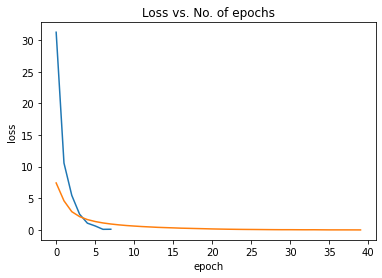

In [39]:
%matplotlib inline
plt.plot(val_losses, label = "val loss")
plt.plot(epoch_losses, label = "epoch loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [42]:
import pickle

a = converter.vocabs

with open('vocabs.pkl', 'wb') as handle:
    pickle.dump(a, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [40]:
# def save_checkpoint(filename):
#     state = {'state_dict': model.state_dict(),
#             'optimizer': optimizer.state_dict()}
        
#     path, _ = os.path.split(filename)
#     os.makedirs(path, exist_ok=True)

#     torch.save(state, filename)

In [41]:
# save_checkpoint('./check/crnn_checkpoint1.pth')